<a href="https://colab.research.google.com/github/tamtran4869/media_effectiveness_analysis/blob/main/Uplift_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uplift modelling with causalml

To assess the outcome (conversions - making a purchase) of a marketing activity (a promotion) in the whole population, sampling and A/B hypothesis testing could be suitable.

However, to know the outcome at the user/individual level, we could use predictive models to predict whether particular users will buy a product. But the outcome may not truly reflect the effect of the promotion on outcomes because there are some customers who make or do not make a purchase regardless of the promotion campaign.

So it is necessary to "put" users into two scenarios (0: no offer the promotion and 1: offer the promotion) and observe how the promotion affects their buying decision (individual treatment effect ITE/conditional average treatment effect CATE).

However, it is impossible to do this simultaneously (a user can not get both the offer and non-offer at the same time).

That is the main reason why we need uplift models.

## Clone and setup the package

In [1]:
%%capture
!git clone https://github.com/uber/causalml.git
%cd causalml
!pip install .
!python setup.py build_ext --inplace
!python setup.py install

## Import libraries

In [2]:
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics.visualize import *
from xgboost import XGBRegressor, XGBClassifier
from causalml.optimize import CounterfactualValueEstimator
from causalml.optimize import get_treatment_costs
from causalml.optimize import get_actual_value
from causalml.metrics.sensitivity import Sensitivity
from causalml.metrics.sensitivity import SensitivityRandomReplace, SensitivitySelectionBias


import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


## Import data

The data includes:
- X variables: `recency`, `history`, `user_discount`, `used_bogo`, `zip_code`, `is_referral`, `channel`
- An outcome variable y: `conversion`
- A condition/treatment variable w: `offer`


The details of the dataset can be found https://www.kaggle.com/datasets/davinwijaya/customer-retention

This notebook addresses only 2 options for the offer (0 = No Offer and 1 = Buy One Get One).

In [3]:
#Importing the data
url='https://drive.google.com/file/d/1vjqiiAWpBv6IO0Fd-Rz8BTgXrIZy1Q2w/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df = df[df['offer'] != 'Discount']
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1


In [4]:
# Check datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42693 entries, 0 to 63998
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        42693 non-null  int64  
 1   history        42693 non-null  float64
 2   used_discount  42693 non-null  int64  
 3   used_bogo      42693 non-null  int64  
 4   zip_code       42693 non-null  object 
 5   is_referral    42693 non-null  int64  
 6   channel        42693 non-null  object 
 7   offer          42693 non-null  object 
 8   conversion     42693 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.3+ MB


In [5]:
# Check statistics of each variable
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000
mean,5.758789,241.711212,0.551074,0.548872,0.502612,0.128827
std,3.504745,254.040262,0.497390,0.497612,0.499999,0.335012
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.160000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,158.460000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,326.050000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Check balance of data
df.pivot_table(values='conversion',
               index='offer',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
offer,,
Buy One Get One,0.151400,21387
No Offer,0.106167,21306
All,0.128827,42693


- The data is kind of balanced between 2 offer options.
- Some categorical variables are not in correct datatypes.

## Preprocess data


In [7]:
# Convert treatment values to 0 for No Offer and 1 for Buy One Get One
df['offer'].replace(['No Offer', 'Buy One Get One'],
                        [0,1], inplace=True)
#Convert datatype of the treatment variable
df['offer'] = df['offer'].astype('str')

In [8]:
# Encode categorical variables
dum = pd.get_dummies(df[['zip_code','channel']])
df = pd.concat([df.drop(['zip_code','channel'],axis =1),dum.drop(['zip_code_Urban',	'channel_Multichannel'],axis = 1)],axis =1)
# Change data type of categorical variables
df[df.columns.difference(['recency','history','conversion'])] = df[df.columns.difference(['recency','history','conversion'])].astype('category')
df.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Rural,zip_code_Surburban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,1,0
1,6,329.08,1,1,1,0,0,1,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,1
4,2,45.34,1,0,0,1,0,0,0,0,1
5,6,134.83,0,1,0,1,1,0,1,1,0


In [9]:
# Classify name of variables
x_names = [i for i in list(df.columns) if i not in ['offer','conversion','p']]
y = 'conversion'
w = 'offer'
p = 'p' # propensity score

In [10]:
# Get propensity score for each user
pm = ElasticNetPropensityModel(n_fold=5, random_state=123)
df['p'] = pm.fit_predict(df[x_names], df[w])

In [14]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Rural,zip_code_Surburban,channel_Phone,channel_Web,p
0,10,142.44,1,0,0,1,0,0,1,1,0,0.501700
1,6,329.08,1,1,1,0,0,1,0,0,1,0.501659
2,7,180.65,0,1,1,1,0,0,1,0,1,0.501368
4,2,45.34,1,0,0,1,0,0,0,0,1,0.499565
5,6,134.83,0,1,0,1,1,0,1,1,0,0.501572


## Uplift models
For example: a user who was offered promotion -> we have the actual outcome of the user given exposed to the promotion P(y|x,w=1)

How do we get the outcome of the user given no offer promotion P(y|x,w=0) to compute the uplift value?

There are some solutions:
- Traditional selection methods like matching: Getting the outcome of a similar user (having the same x or defined features or same propensity score) who was not offered the promotion.
- Meta-learner methods: use one or more machine learning models to predict the outcome.
- Tree-based method: As I understand, this method works directly with uplift values between groups that were split by criteria, so it is normally used in case checking variance of uplift between groups.

In this example, the outcome `y` is binary so classifier models are used.

In [15]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11101)
n_test = df_test.shape[0]
n_train = df_train.shape[0]

print(n_test, n_train)

8539 34154


### Tree-based methods

In [16]:
# Tree-base method
uplift_model = UpliftRandomForestClassifier(control_name='0')
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train[w].values,
                 y=df_train[y].values)
# Result
df_res = uplift_model.predict(df_test[x_names].values, full_output=True)
df_res.head()

(8539, 5)


,0,1,recommended_treatment,delta_1,max_delta
0,0.127627,0.136492,1,0.008866,0.008866
1,0.098156,0.118319,1,0.020162,0.020162
2,0.097686,0.118221,1,0.020534,0.020534
3,0.091525,0.156168,1,0.064643,0.064643
4,0.087007,0.119744,1,0.032738,0.032738


Text(0, 0.5, '# of Samples')

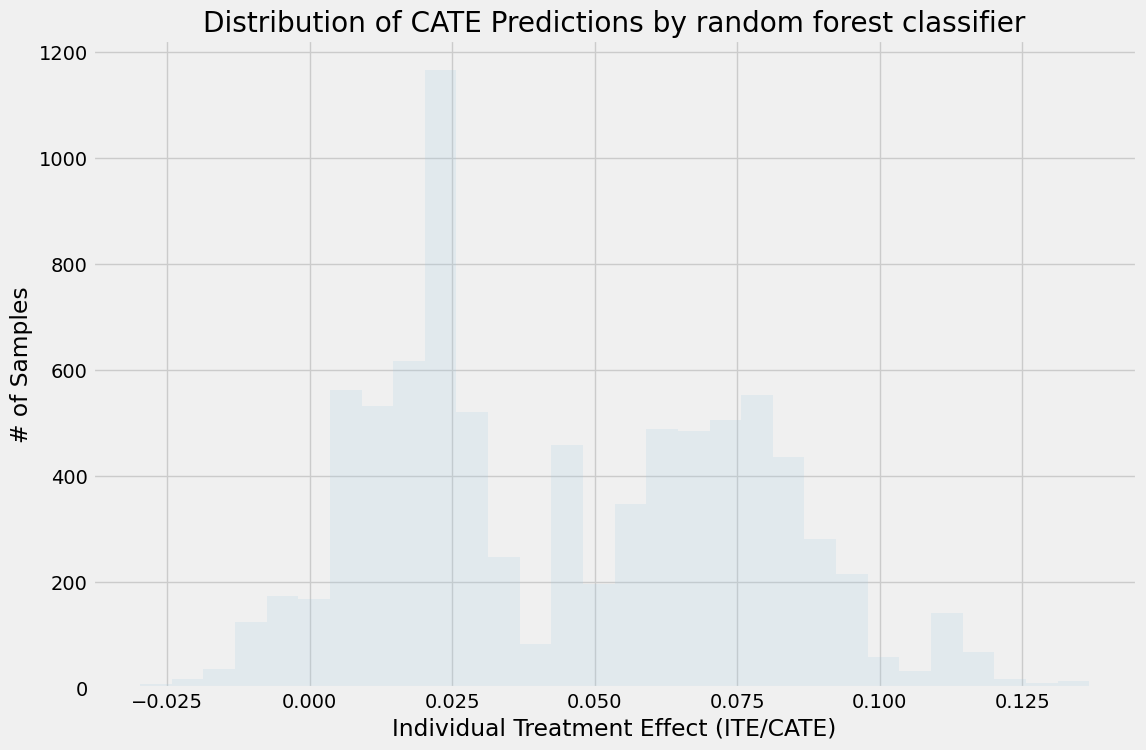

In [18]:
# Distribution of CATE
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(df_res['delta_1'], alpha=alpha, bins=bins)

plt.title('Distribution of CATE Predictions by random forest classifier')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')

used_discount >= 0.1?
yes -> zip_code_Rural >= 0.1?
		yes -> history >= 53.378?
				yes -> history >= 80.565?
						yes -> [0.18108651911468812, 0.18086124401913875]
						no  -> [0.07272727272727272, 0.19658119658119658]
				no  -> recency >= 9.0?
						yes -> [0.09473684210526316, 0.09375]
						no  -> [0.16666666666666666, 0.07142857142857142]
		no  -> recency >= 3.0?
				yes -> used_bogo >= 0.1?
						yes -> [0.13479623824451412, 0.20620842572062084]
						no  -> [0.08633093525179857, 0.09625559625559625]
				no  -> is_referral >= 0.1?
						yes -> [0.11053089643167972, 0.19391947411668037]
						no  -> [0.15264187866927592, 0.18723849372384938]
no  -> recency >= 9.0?
		yes -> channel_Phone >= 0.1?
				yes -> history >= 165.8?
						yes -> [0.07758620689655173, 0.17307692307692307]
						no  -> [0.023017902813299233, 0.12385321100917432]
				no  -> history >= 484.37?
						yes -> [0.14666666666666667, 0.12698412698412698]
						no  -> [0.08076009501187649, 0.17534456355283307]
		no

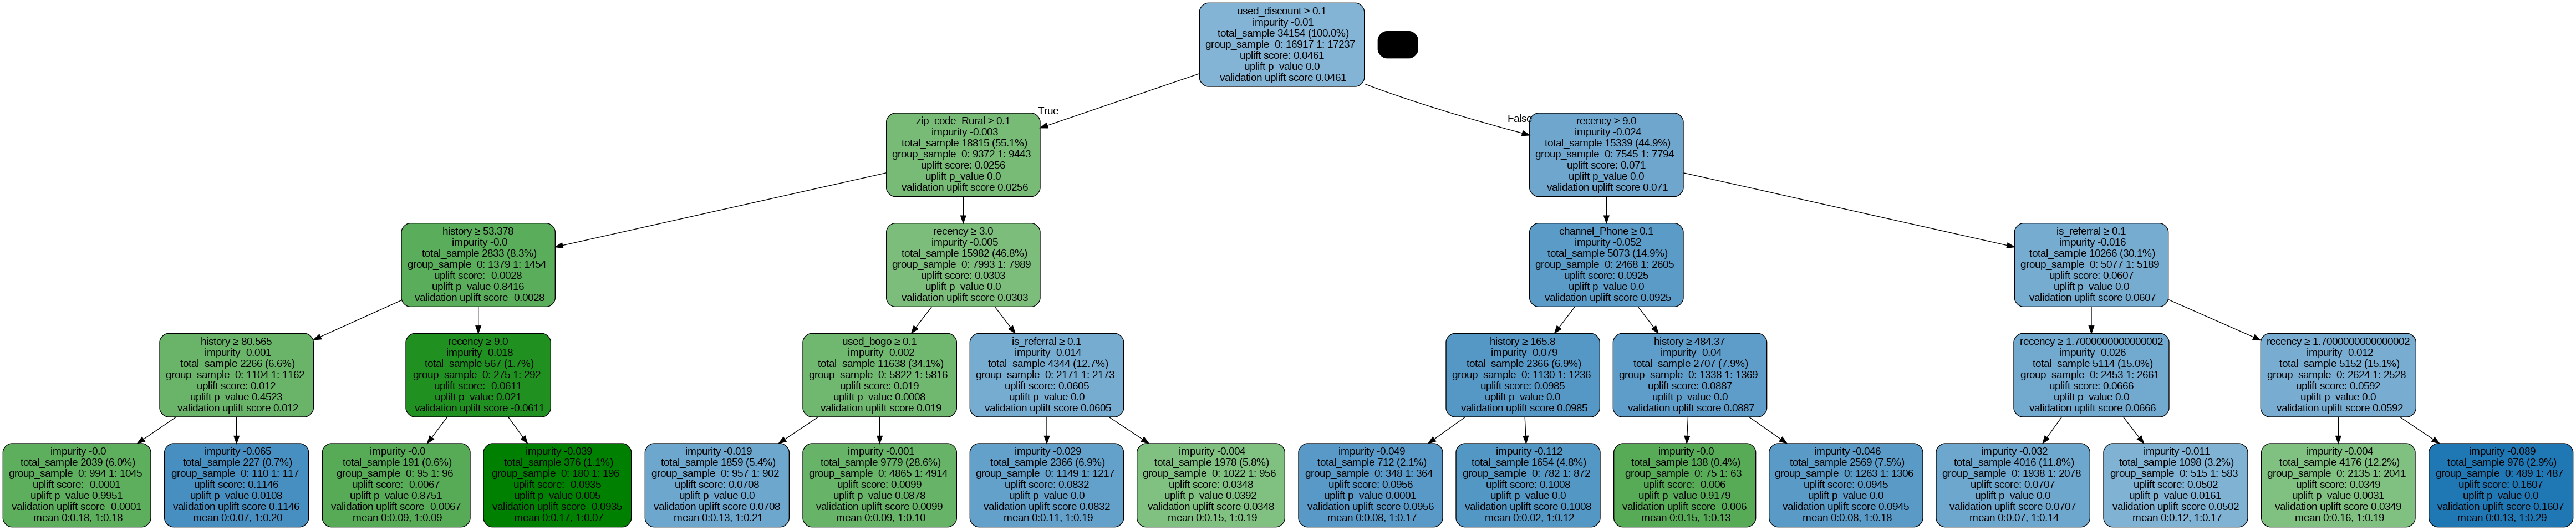

In [19]:
# Specify a tree in the random forest
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Meta learners

Learners have different approaches to predict the potential outcome of computing ITE.
- S: uses one model.
- X: uses 2 models (one for no offer group and one for buy one get one group) and weight ITE with propensity score.
- R: use 2 models with cross-validation, propensity score and R-loss.

More details: https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms

In [20]:
# S learner
learner_s = BaseSClassifier(XGBClassifier(), control_name='0')
learner_s.fit(X=df_train[x_names], treatment=df_train[w], y=df_train[y])
ite_s = learner_s.predict(X=df_test[x_names], treatment=df_test[w],p = df_test[p])
ite_s

array([[ 0.01633671],
       [ 0.01598364],
       [-0.00514999],
       ...,
       [ 0.07837874],
       [ 0.06670447],
       [ 0.04600535]])

In [21]:
# X learner
learner_x = BaseXClassifier(outcome_learner = XGBClassifier(),
                            effect_learner = XGBRegressor(),
                            control_name='0')
learner_x.fit(X=df_train[x_names], treatment=df_train[w], y=df_train[y], p = df_train[p])
ite_x = learner_x.predict(X=df_test[x_names], treatment=df_test[w],p = df_test[p])
ite_x

array([[-0.03234472],
       [-0.04185232],
       [ 0.0072944 ],
       ...,
       [ 0.10590804],
       [ 0.09125343],
       [ 0.04373923]])

In [22]:
# R learners
learner_r = BaseRClassifier(outcome_learner = XGBClassifier(),
                            effect_learner = XGBRegressor(),
                            control_name='0')
learner_r.fit(X=df_train[x_names], treatment=df_train[w], y=df_train[y], p = df_train[p])
ite_r = learner_r.predict(X=df_test[x_names],p = df_test[p])
ite_r

array([[-0.0640805 ],
       [-0.09823055],
       [-0.01113107],
       ...,
       [ 0.04588117],
       [ 0.03164681],
       [ 0.11830585]])

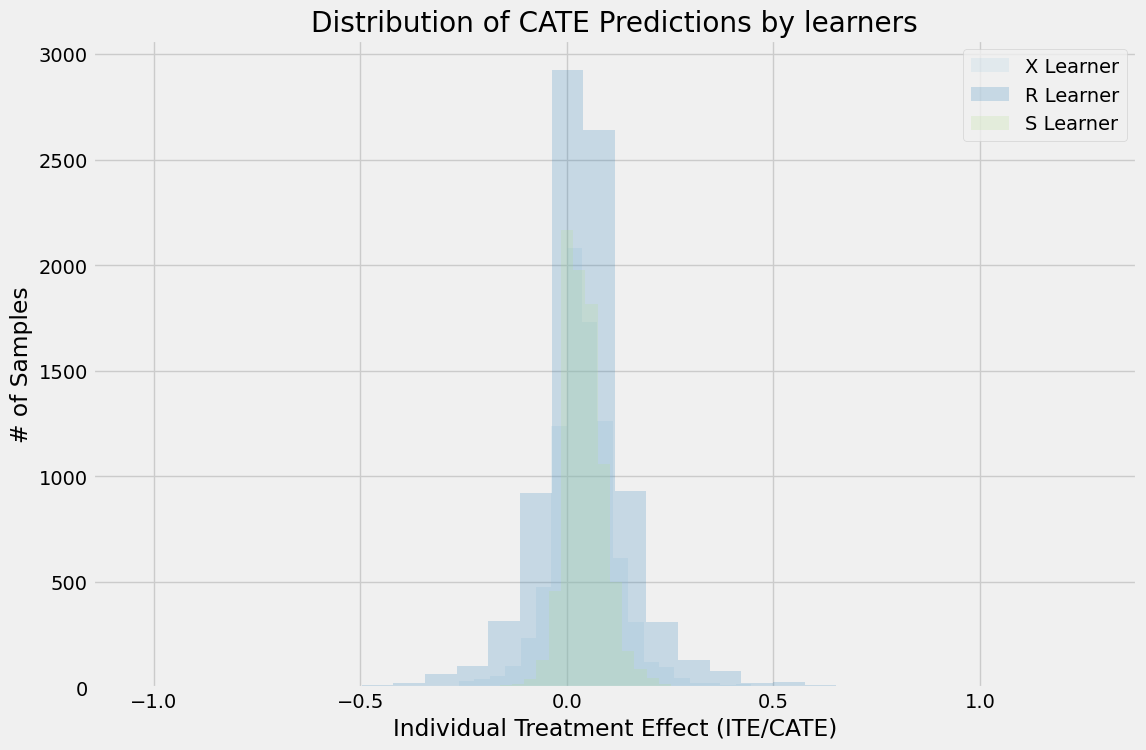

In [23]:
# Distribution of treatment effects
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(ite_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(ite_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(ite_s, alpha=alpha, bins=bins, label='S Learner')

plt.title('Distribution of CATE Predictions by learners')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

In [24]:
# Concat results
res = pd.concat([df_test[y],
                 df_test[w].astype('int64'),
                 pd.DataFrame(ite_s,columns = ['s_learner'],index = df_test.index),
                 pd.DataFrame(ite_x,columns = ['x_learner'],index = df_test.index),
                 pd.DataFrame(ite_r,columns = ['r_learner'],index = df_test.index)],
                 #pd.DataFrame(np.array(df_res['delta_1']),columns = ['treatment_tree'],index = df_test.index)],
                axis=1)

res

,conversion,offer,s_learner,x_learner,r_learner
8569,0,0,0.016337,-0.032345,-0.064080
29090,0,1,0.015984,-0.041852,-0.098231
5831,0,1,-0.005150,0.007294,-0.011131
36597,0,0,0.026247,-0.029749,-0.051179
9402,0,0,0.030531,0.095828,0.106216
...,...,...,...,...,...
23367,0,1,0.097848,0.237708,0.369542
21501,0,1,0.025309,0.001188,0.010592
17315,0,1,0.078379,0.105908,0.045881
50655,0,0,0.066704,0.091253,0.031647


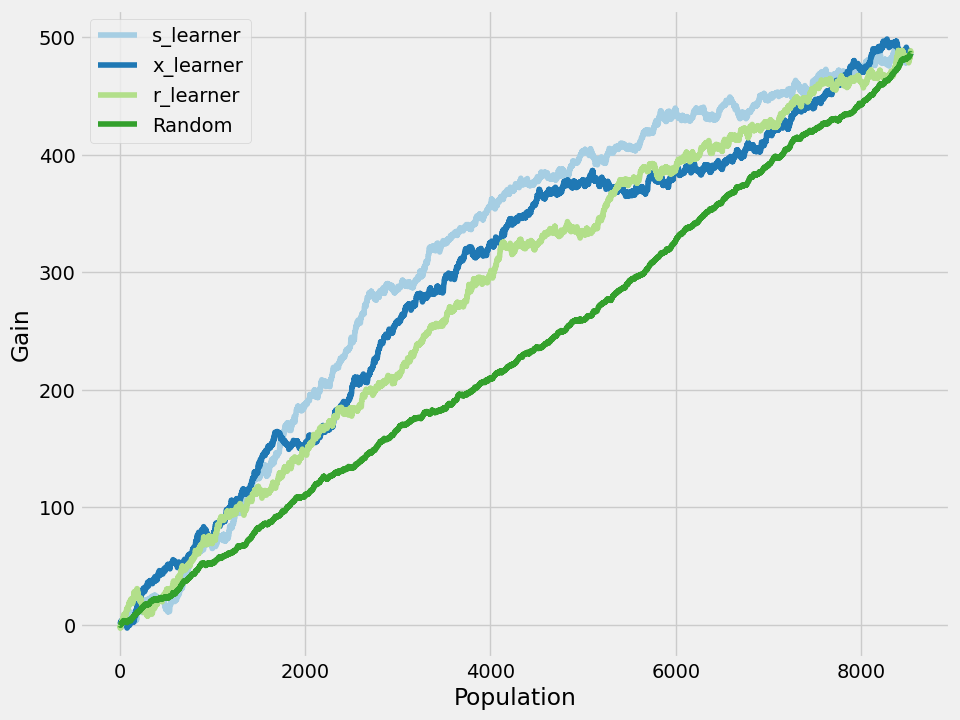

In [41]:
# Plot cumulative gain chart
plot_gain(res,
          outcome_col=y,
          treatment_col=w,
          treatment_effect_col= None,
          n = res.shape[0],
          figsize=(10,8)
         )

All learners gave us better cumulative uplift than random. S learner has the highest result. Look at the S learner curve, from 0 to around 3000 users, the curve increased. From 3000 to around 6000 users, it stayed still and started to decrease from 6000 users. It means, in our test dataset, as the S learner results, we have:

- Around 3000 users who will buy the products if they get an offer.
- Around 3000 users do not care about the offer.
- Around 2500 users are annoyed by the offer and don't want to buy anymore.

From the ITE values, we could easily decide which users to offer the promotion who are more likely to convert due to the promotion.

### Get sales and costs involved

We take the cost of conversion and impression and also the values for each conversion into account to make sure that we choose the correct users to advertise which helps us drive more sales instead of just more conversions.

The `causalml` package has a function `CounterfactualValueEstimator` to do this

In this case, we assume the cost of sending out the offer is 1, the cost of the offer is 2.5 and with each purchase made, we get 20 back.


In [26]:
# Assign cost
conversion_cost_dict = {'0': 0, '1': 2.5}
impression_cost_dict = {'0': 0, '1': 1}

# Use a helper function to put treatment costs to array
cc_array, ic_array, conditions = get_treatment_costs(treatment=df_test[w],
                                                     control_name='0',
                                                     cc_dict=conversion_cost_dict,
                                                     ic_dict=impression_cost_dict)

# Put the conversion value into an array
conversion_value_array = np.full(df_test.shape[0], 20)

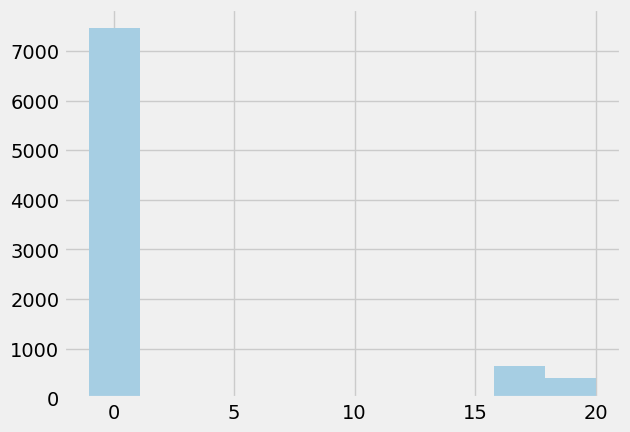

In [27]:
# Use a helper function to obtain the value of actual treatment
actual_value = get_actual_value(treatment=df_test[w],
                                observed_outcome=df_test[y],
                                conversion_value=conversion_value_array,
                                conditions=conditions,
                                conversion_cost=cc_array,
                                impression_cost=ic_array)

plt.hist(actual_value)
plt.show()

To see how the function helps us drive more values, we compare with:
- Random allocation: Mean value of randomly choosing users to advertise -> get the mean value of all users in the test set (because the test set is randomly split above).

In [28]:
# Calculate the benchmark value according to the random allocation
random_allocation_value = actual_value.mean()


- Best treatment: from train data -> get the name of the best treatment with the highest mean conversion (in this case, the best treatment is 1 - Buy one get one) -> get the mean value of only users in the test dataset who have actual treatments same as the best treatment.

In [29]:
# Best treatment
best_ate = df_train.groupby(w)[y].mean().idxmax()
actual_is_best_ate = df_test[w] == best_ate
best_ate_value = actual_value[actual_is_best_ate].mean()

- S - Learner suggested allocation: From ITE values from S learner -> assign best treatment for each user in the test data (ITE <= 0 means they don't care or are annoyed by the promotion we should not send them offers) -> get the mean value of users in the test dataset who have their actual treatment same as the suggested treatment by S learner.

In [30]:
# S learner
s = np.where(ite_s <= 0,'0','1')
actual_is_best = df_test[w] == s.ravel()
s_value = actual_value[actual_is_best].mean()

In [32]:
 # Run the counterfactual calculation with S learner
cve = CounterfactualValueEstimator(treatment=df_test[w],
                                   control_name='0',
                                   treatment_names=['1'],
                                   y_proba=df_test[p],
                                   cate=ite_s,
                                   value=conversion_value_array,
                                   conversion_cost=cc_array,
                                   impression_cost=ic_array)

cve_best_idx = cve.predict_best()
cve_best = [conditions[idx] for idx in cve_best_idx]
actual_is_cve_best = df_test[w] == cve_best
cve_value = actual_value[actual_is_cve_best].mean()

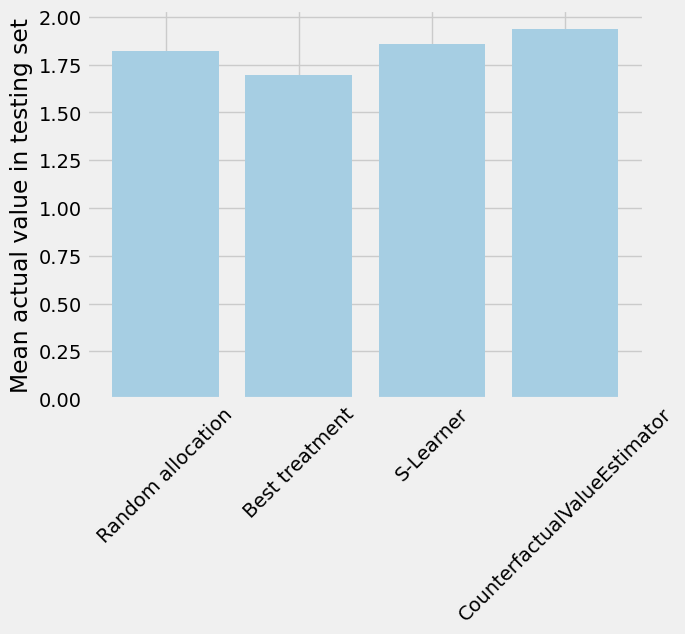

In [33]:
# Visualise results
labels = [
    'Random allocation',
    'Best treatment',
    'S-Learner',
    'CounterfactualValueEstimator'
]

values = [
    random_allocation_value,
    best_ate_value,
    s_value,
    cve_value
]

plt.bar(labels, values)
plt.ylabel('Mean actual value in testing set')
plt.xticks(rotation=45)
plt.show()


As the chart shows, the function helps us select users to gain the highest mean value while the suggested allocation by S learner is slightly better than random allocation and mass sending out offers clearly is not a good approach.

## Sensitivity Analysis

The purpose of sensitivity analysis is to check unobserved confounders with some methods:
- Placebo Treatment: Replace treatment with a random variable.
- Irrelevant Additional Confounder: Add a random common cause variable.
- Subset validation: Remove a random subset of the data.
- Random Replace: Random replace a covariate with an irrelevant variable.
- Selection Bias

In [48]:
# Calling the Base SLearner class and return the sensitivity analysis summary report
learner = BaseXClassifier(outcome_learner = XGBClassifier(),
                            effect_learner = XGBRegressor(),
                            control_name=0)
df['w_no'] = df[w].astype('int')
sens_x = Sensitivity(df=df, inference_features= x_names, p_col= p,
                     treatment_col= 'w_no', outcome_col= y,
                     learner=learner)

# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x = sens_x.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace'], sample_size=0.5)

sens_sumary_x

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,0.045524,0.001473,-0.004257,0.007204
1,Random Cause,0.045524,0.044976,0.039446,0.050506
2,Subset Data(sample size @0.5),0.045524,0.045283,0.037591,0.052975
3,Random Replace,0.045524,0.045193,0.039643,0.050742


The result shows the model is robust. Adding an irrelevant variable and randomly removing a subset do not change ATE much which is good.

The treatment variable has an important role in the model.

The only thing I think could be a problem is when replacing a covariate x with an irrelevant variable, the ATE just has a slight decrease. It may indicate some insignificant covariates in x features.


There are more functions in `causalml` package for feature selection, and continuous outcome.

I am learning and would greatly appreciate any suggestions. Thank you.

#REFERENCES
https://github.com/uber/causalml/tree/master

https://causalml.readthedocs.io/en/latest/index.html

A very clear introduction about uplift and causal inference: https://www.youtube.com/watch?v=MFnOYNU5sbk&t=186s

An interesting course about some rare skills for data scientists: https://www.coursera.org/learn/four-rare-machine-learning-skills-all-data-scientists-need

